## Comparison of ELMo and InferSent on Consumer Complaints Dataset

In [24]:
## Import Libraries

import warnings 
warnings.simplefilter('ignore')
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import os
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from joblib import parallel_backend
from models import InferSent  ##models.py 
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import time
import torch
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import sklearn
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import contextlib
from collections import Counter
import string
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to /home/h0052976/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/h0052976/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/h0052976/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/h0052976/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/h0052976/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/h0052976/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### In this work, we utilize the following software versions: TensorFlow 2.11, Python 3.8.16, CUDA 11.7, and PyTorch 2.0.0

### Descriptive Data Analysis and Data Preprocessing

In [7]:
#importing dataset

df= pd.read_csv("complaints.csv", encoding= 'unicode_escape')
df.head()

Date received                                            Product   
0    2022-10-27  Credit reporting, credit repair services, or o...  \
1    2022-10-21                                           Mortgage   
2    2022-10-19                                           Mortgage   
3    2022-10-13                                           Mortgage   
4    2022-10-28  Credit reporting, credit repair services, or o...   

        Sub-product                                              Issue   
0  Credit reporting               Incorrect information on your report  \
1       VA mortgage  Applying for a mortgage or refinancing an exis...   
2       VA mortgage                         Struggling to pay mortgage   
3       VA mortgage                     Trouble during payment process   
4  Credit reporting               Incorrect information on your report   

                             Sub-issue Consumer complaint narrative   
0             Account status incorrect                          NaN  \
1                                  NaN                          NaN   
2                                  NaN                          NaN   
3                                  NaN                          NaN   
4  Information belongs to someone else                          NaN   

                             Company public response   
0                                                NaN  \
1  Company has responded to the consumer and the ...   
2  Company has responded to the consumer and the ...   
3  Company has responded to the consumer and the ...   
4                                                NaN   

                    Company State ZIP code           Tags   
0             EQUIFAX, INC.    NY  10457.0            NaN  \
1  Freedom Mortgage Company    KY  40047.0  Servicemember   
2  Freedom Mortgage Company    TX  76502.0  Servicemember   
3  Freedom Mortgage Company    VA  22308.0  Servicemember   
4             EQUIFAX, INC.    CA  93560.0            NaN   

  Consumer consent provided? Submitted via Date sent to company   
0                        NaN           Web           2022-10-27  \
1                        NaN           Web           2022-10-21   
2                        NaN           Web           2022-10-19   
3       Consent not provided           Web           2022-10-13   
4                        NaN           Web           2022-10-28   

  Company response to consumer Timely response? Consumer disputed?   
0                  In progress              Yes                NaN  \
1      Closed with explanation              Yes                NaN   
2      Closed with explanation              Yes                NaN   
3      Closed with explanation              Yes                NaN   
4                  In progress              Yes                NaN   

   Complaint ID  
0       6133674  
1       6112254  
2       6105001  
3       6084363  
4       6134907

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3033308 entries, 0 to 3033307
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 416.

In [8]:
# only select 'Consumer complaint narrative' column and drop missing values.

df2= pd.DataFrame(df['Consumer complaint narrative'])
df2.dropna(inplace= True)
df2.head()
len(df2)


1087560

In [9]:
# number of unique values in dataframe and drop duplicates

df2.drop_duplicates(inplace= True)
df2.nunique()
df2.head()

Consumer complaint narrative
114  On XX/XX/XXXX, I bought a car from XXXX XXXX. ...
118  On XX/XX/22, I submitted a dispute to my credi...
158  IM A VICTIM OF IDENTITY THEFT I am writing in ...
163  I paid my individual portion prior to XXXX in ...
245  As the executor of my mother 's estate I sold ...

In [10]:
## reset index of dataframe

df2.reset_index(drop=True, inplace = True)
df2.head()

Consumer complaint narrative
0  On XX/XX/XXXX, I bought a car from XXXX XXXX. ...
1  On XX/XX/22, I submitted a dispute to my credi...
2  IM A VICTIM OF IDENTITY THEFT I am writing in ...
3  I paid my individual portion prior to XXXX in ...
4  As the executor of my mother 's estate I sold ...

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951793 entries, 0 to 951792
Data columns (total 1 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Consumer complaint narrative  951793 non-null  object
dtypes: object(1)
memory usage: 7.3+ MB


#### Data Cleaning

In [3]:
punctuation = '!"#$%&()*+-/:;,<=>?@[\\]^_`{|}~'

corrections = {
    "A":"a",
    "im": "I am",
    "dont": "don't",
    "cant": "can't",
    "wont": "won't",
    "isnt": "isn't",
    "arent": "aren't",
    "didnt": "didn't",
    "doesnt": "doesn't",
    "hasnt": "hasn't",
    "havent": "haven't",
    "hadnt": "hadn't",
    "couldnt": "couldn't",
    "shouldnt": "shouldn't",
    "wouldnt": "wouldn't",
    "wasnt": "wasn't",
    "werent": "weren't",
    "gonna": "going to",
    "wanna": "want to",
    "ive": "I have",
    "youve": "you have",
    "weve": "we have",
    "theyve": "they have",
    "youre": "you're",
    "were": "we're",
    "theyre": "they're",
    "whos": "who's",
    "whats": "what's",
    "wheres": "where's",
    "whens": "when's",
    "whys": "why's",
    "hows": "how's",
    #"id": "I'd",
    "youd": "you'd",
    "hed": "he'd",
    "shed": "she'd",
    "wed": "we'd",
    "theyd": "they'd",
    "itd": "it'd",
    "ill": "I'll",
    "youll": "you'll",
    "hell": "he'll",
    "shell": "she'll",
    "itll": "it'll",
    "well": "we'll",
    "theyll": "they'll",
    "thats": "that's",
}


def remove_punctuations(text):
    for p in punctuation:
        text= text.replace(p, " ")
    return text

def replace_whole_words(text, old_word, new_word):
    pattern = r'\b{}\b'.format(old_word)
    return re.sub(pattern, new_word, text, flags=re.IGNORECASE)

def remove_wrong_spelling(text):
    corrected = text
    for k, v in corrections.items():
        corrected = replace_whole_words(corrected, k, v)
    return corrected


def remove_wrong_spelling_orig(text):
    tokens = text.split()
    for k, v in word_change.items():
        tokens = [token.replace(k, v) if token == k else token for token in tokens]
    return " ".join(tokens)
    
def remove_consecutive_spaces(text):
    return re.sub(r"\s+", " ", text).strip() #remove whitespaces
    
def clean_text(text):
    if(len(text) == 0):
        return []
    
    text= text.str.replace(r"\n"," ", regex=False) #remove \n 
    
    text= text.str.replace(r"X{2,}"," ", regex=True) # remove XXX%
    
    text= text.str.replace(r'\d+',' ', regex=True)  # remove numbers
      
    return [remove_consecutive_spaces(remove_wrong_spelling(remove_punctuations(t))) for t in text]

#### Analyzing word frequency using bar chart and word colud

In [37]:
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
noun_tag_set = set(['NN', 'NNS', 'NNP', 'NNPS'])
lemmatizer = WordNetLemmatizer()

def process_pos_tags(chunk):
    return [lemmatizer.lemmatize(word) for word, pos in chunk if pos in noun_tag_set and word not in stop_words and word not in punctuations]

def extract_nouns(words, logger):
    start_time = time.time()
    logger.info('extract_nouns - start')
    pos_tags = nltk.pos_tag(words)
    
    # Extract only nouns    
    #nouns = parallel_noun_extraction(pos_tags)
    nouns = process_pos_tags(pos_tags)
    
    time_diff = time.time() - start_time
    logger.info('extract_nouns - nouns len: %d, time: %f', len(nouns), time_diff)
    
    return nouns
    


In [8]:
# create a logger instance
logger_word_freq = logging.getLogger('word_freq')

# set the logger level to INFO
logger_word_freq.setLevel(logging.INFO)

# create a file handler and set its level to INFO
file_handler = logging.FileHandler('logs/word_freq.log')
file_handler.setLevel(logging.INFO)

# create a formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
#console_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)

# add the handlers to the logger
logger_word_freq.addHandler(file_handler)

In [39]:
# Getting word frequencies

def get_word_freq(text_series):    
    words_list = []
    cleaned_text = clean_text(text_series)   

    with open('word_list.npy', 'w') as f:
        total_word_count = 0;
        for text in cleaned_text:
            start_time = time.time()

            #logger_word_freq.info(text)
            words = word_tokenize(text)  # Split the text into words        
            nouns = extract_nouns(words, logger_word_freq)
            total_word_count += len(nouns)
            
            nouns = [noun.lower() for noun in nouns]
            logger_word_freq.info(nouns)
            np.savetxt(f, np.array(nouns),fmt="%s", delimiter='\n')
            time_diff = time.time() - start_time
        logger_word_freq.info('total word count: %d', total_word_count)
   
      
get_word_freq(df2['Consumer complaint narrative'][0:500000])        

In [2]:
file_name = 'word_list.npy'
loaded_words_list = np.loadtxt(file_name, dtype='U')
print(len(loaded_words_list))

23933324


In [3]:
# Counting each word 
word_counter = Counter(loaded_words_list)
common_words = word_counter.most_common(20) 

In [4]:
common_words

[('account', 939364),
 ('credit', 927327),
 ('payment', 461218),
 ('report', 437850),
 ('information', 404936),
 ('loan', 294826),
 ('time', 280887),
 ('debt', 265726),
 ('company', 259094),
 ('bank', 255303),
 ('card', 239165),
 ('day', 229578),
 ('consumer', 222553),
 ('letter', 215248),
 ('reporting', 188456),
 ('number', 178149),
 ('balance', 173451),
 ('date', 161724),
 ('month', 160774),
 ('amount', 158733)]

#### Bar Chart for Most Common Words

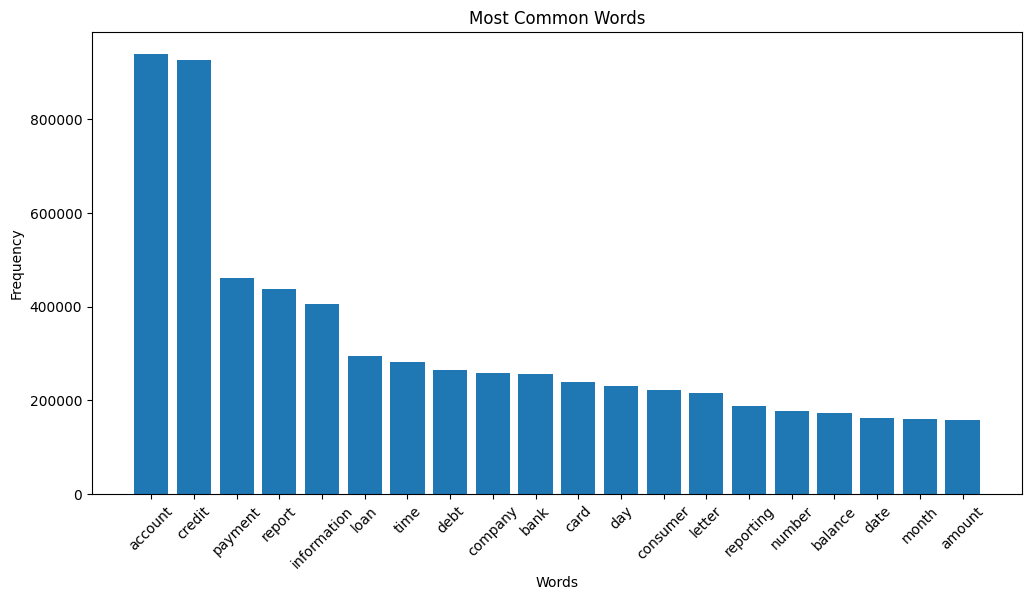

In [43]:
plt.figure(figsize=(12, 6))
words, frequencies = zip(*common_words)
plt.xticks(rotation=45)
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words')
plt.show()


#### Word Cloud

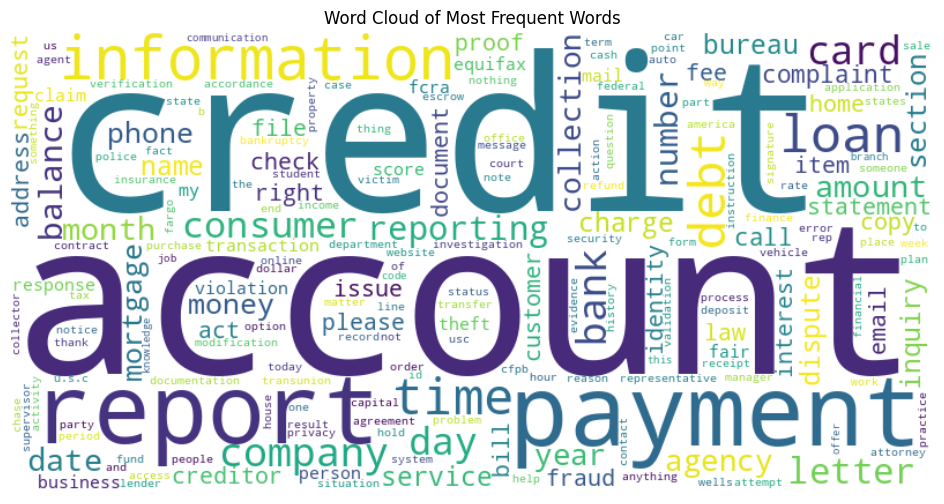

In [5]:

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()


### Distribution of the length of complaints

##### Our dataset consists of consumer complaints regarding financial products and services, described in the customers' own words. As a result, the entries are not always grammatically correct. Sometimes, due to the lack of punctuation, a long paragraph may be counted as a single sentence, even though it contains multiple sentences. For this reason, we consider the number of words in each entry instead of the number of sentences to get the length of each row.

In [12]:
get_num_words = lambda row: len(word_tokenize(row))

# Apply the lambda function to each row of the Series
num_words = df2['Consumer complaint narrative'][0:500000].apply(get_num_words)

print(num_words[0:15])


0     119
1     209
2     564
3     141
4     518
5     647
6     271
7     125
8     542
9     227
10    719
11    208
12    136
13    498
14     84
Name: Consumer complaint narrative, dtype: int64


#### Box Plot

The length of shortest complaint: 1
The length of longest complaint: 6715
Lower whisker point: 1
Upper whisker point: 557


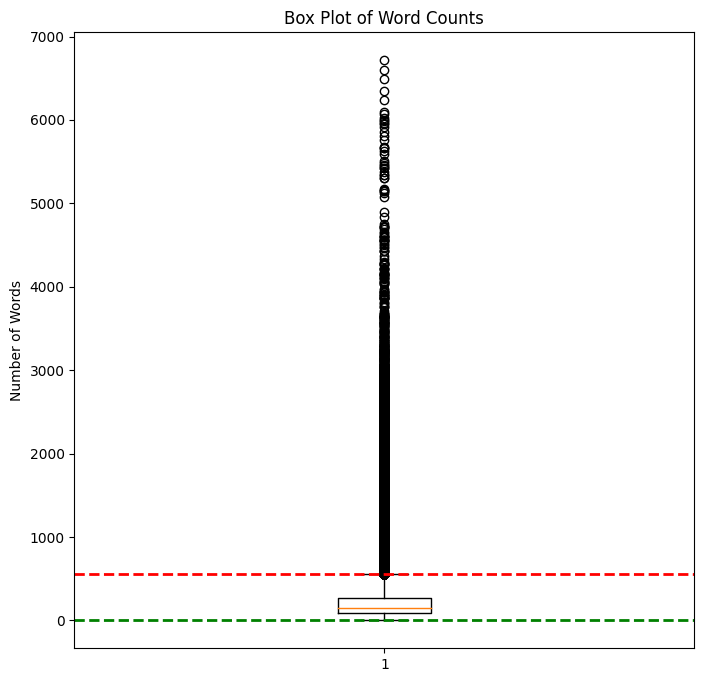

In [13]:
Q1 = np.percentile(num_words, 25)
Q3 = np.percentile(num_words, 75)
IQR = Q3 - Q1

lower_whisker_range = num_words[num_words >= Q1 - 1.5*IQR]
lower_whisker = min(lower_whisker_range)

upper_whisker_range = num_words[num_words <= Q3 + 1.5*IQR]
upper_whisker = max(upper_whisker_range)

print("The length of shortest complaint:", min(num_words))
print("The length of longest complaint:", max(num_words))
print("Lower whisker point:", lower_whisker)
print("Upper whisker point:", upper_whisker)

plt.figure(figsize=(8, 8))
plt.boxplot(num_words)
plt.axhline(y=upper_whisker, color='red', linestyle='--', linewidth=2)
plt.axhline(y=lower_whisker, color='green', linestyle='--', linewidth=2)
plt.ylabel('Number of Words')
plt.title('Box Plot of Word Counts')
plt.show()


In [76]:

q1, q2, q3 = np.percentile(num_words, [25, 50, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

outliers = [x for x in num_words if x < lower_bound or x > upper_bound]
print(len(outliers))


28012


#### In our dataset, the lower whisker point is 1 and the upper whisker point is 557. This means that any values below 1 or above 557 are considered outliers. We do not have any values smaller than 1. In this case, we only have outliers greater than 557, with a total of 28012 outliers out of 500000 values.  

### ELMo and InferSent Embeddings

#### Due to memory constraints, we read and process the data in smaller segments called batches or chunks. Then we apply the ELMo and InferSent embeddings models separately to each chunk. The resulting outputs are then stored in files. Initially, we attempted to implement both ELMo and InferSent models concurrently. However, due to the high computational demands of the models, we encountered memory issues.

#### ELMo Word Embeddings

In [4]:
# Checking GPU availability

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU available")
    for gpu in physical_devices:
        print(gpu)
        
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU available")
    

GPU available
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
# deleting logfile, if needed

files_to_delete = ['logs/elmo.log']

for file_to_delete in files_to_delete:
    if os.path.isfile(file_to_delete):
        os.remove(file_to_delete)
        print(f"The file '{file_to_delete}' has been deleted.")
    else:
        print(f"The file '{file_to_delete}' does not exist.")

The file 'logs/elmo.log' has been deleted.


In [6]:
root_logger = logging.getLogger()

# Remove any existing handlers from the root logger
for handler in root_logger.handlers:
    root_logger.removeHandler(handler)

In [7]:
# create a logger instance
logger= logging.getLogger('elmo')

logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('logs/elmo.log')
file_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

file_handler.setFormatter(formatter)

logger.addHandler(file_handler)

In [8]:
#Loading ELMo model and generating elmo_vector method

elmo = hub.load("https://tfhub.dev/google/elmo/3")

def elmo_vector(x):
    embeddings = elmo.signatures["default"](tf.constant(x))["elmo"]
    return tf.reduce_mean(embeddings, axis=1)

2023-04-26 18:15:42.618882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 18:15:45.079461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21784 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:a1:00.0, compute capability: 8.0


In [ ]:
# Because of memory issues we read our data in batches. 

column_name = 'Consumer complaint narrative'

# Defining the size of each chunk (in rows)
row_chunk_size = 500

output_path_elmo = 'elmo_embeddings_chunks.txt'

# Open the CSV file and read the first chunk
filename = 'complaints.csv'
reader = pd.read_csv(filename, usecols=[column_name], chunksize=row_chunk_size)
chunk = next(reader)

max_total_chunks = 500000

total_time = 0

total_chunks = 0
chunk_size = 5

def embeddings(text, feature_extractor, total_sentence,logger):
    start_time = time.time()                    
    embeddings = feature_extractor(text)                    
    end_time = time.time()
    time_diff = end_time - start_time    
    logger.info('current total chunk: %d, current processed chunks size: %d, total sentences in chunk: %d , processing time: %f ',total_chunks, len(text), total_sentence, time_diff)
    
    return (embeddings, time_diff)


try:
    with open(output_path_elmo, 'w') as elmo_output:
       

        while chunk is not None and total_chunks < max_total_chunks:
            selected_column = chunk[column_name]
            selected_column.dropna(inplace= True)
            selected_column.drop_duplicates(inplace= True)
                        
            if len(selected_column) > 0:
                text_total_chunks = len(selected_column) // chunk_size + (1 if len(selected_column) % chunk_size > 0 else 0)

                for i in range(text_total_chunks):
                    start_idx = i * chunk_size
                    end_idx = min((i + 1) * chunk_size, len(selected_column))


                    sub_text = selected_column.iloc[start_idx:end_idx]

                    if ((total_chunks + len(sub_text)) > max_total_chunks):
                        end_idx -= (total_chunks + len(sub_text)) - max_total_chunks
                        sub_text = selected_column.iloc[start_idx:end_idx]            
                    
                    total_sentence = sum(len(sent_tokenize(p)) for p in sub_text.values)
                    cleaned_text = clean_text(sub_text)
                    
                    
                    elmo_embeddings = embeddings(cleaned_text,elmo_vector,total_sentence,logger)
                    np.savetxt(elmo_output, elmo_embeddings[0])
                    total_time += elmo_embeddings[1]

                    total_chunks += len(sub_text)
                    if(total_chunks == max_total_chunks):
                        logger.info('max total chunks reached!')
                        break;

                
            chunk = next(reader, None)                
except Exception as e:
        logger.exception('An unexpected error occurred: %s', str(e))

logger.info("Total chunks size: " + str(total_chunks))        
logger.info("Total processing time: " + str(total_time) + " seconds")  


#### After analyzing the ELMo log file, it was noted that the processing time increases significantly beyond 500000 rows, resulting in the kernel crashing. Hence, we decided to limit our comparison of the two methods to a maximum of 500000 rows to ensure accurate results. 

In [93]:
# Loading our embeddings
elmo_embeddings = np.loadtxt('elmo_embeddings_chunks.txt')

In [29]:
elmo_embeddings.shape

(500000, 1024)

In [30]:
# reading the input_data.txt file, which contains the batches of data used in our project.

with open('cleaned_text_data.txt', 'r') as f:
    text = f.read()

In [82]:
paragraphs = text.strip().split('\n')
print(len(paragraphs))

500000


#### MiniBatchKmeans with ELMo

#### To ensure optimal performance when implementing MiniBatchKmeans, we first utilize the Elbow Method to determine the optimal number of clusters (k). Additionally, we improve processing speed by parallelizing the MiniBatchKmeans implementation, allowing for the utilization of all available cores.

128.73680591583252


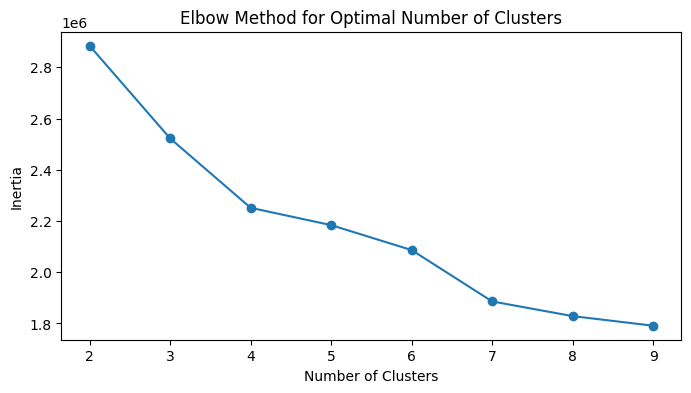

In [32]:
# Using the Elbow Method with MiniBatchKMeans to identify the optimal number of clusters.

cluster_range = range(2, 10)
inertias = []

start_time = time.time() 

with parallel_backend(backend='loky', n_jobs=-1):
    for n_clusters in cluster_range:
        mbkmeans_elmo = MiniBatchKMeans(n_clusters=n_clusters, n_init = 'auto', batch_size=2048, random_state=42, max_iter=100, verbose=0)
        mbkmeans_elmo.fit(elmo_embeddings)
        inertias.append(mbkmeans_elmo.inertia_)

        
end_time = time.time()         
print(end_time - start_time)

plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [94]:
mbkmeans_elmo = MiniBatchKMeans(n_clusters=4, n_init = 'auto', batch_size=2048, random_state=42, max_iter=100, verbose=0)
start_time = time.time()
mbkmeans_elmo.fit(elmo_embeddings)
end_time = time.time() 
total_time = end_time - start_time
print(total_time)
labels_elmo= mbkmeans_elmo.labels_
print(len(labels_elmo))

23.892755270004272
500000


In [34]:
wordcloud_logger = logging.getLogger('wordcloud')

# set the logger level to INFO
wordcloud_logger.setLevel(logging.INFO)

# create a file handler and set its level to INFO
file_handler = logging.FileHandler('logs/wordcloud.log')
file_handler.setLevel(logging.INFO)

# create a formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

#console_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)

wordcloud_logger.addHandler(file_handler)

In [41]:
print(len(paragraphs))

500000


#### Word cloud for each generated cluster

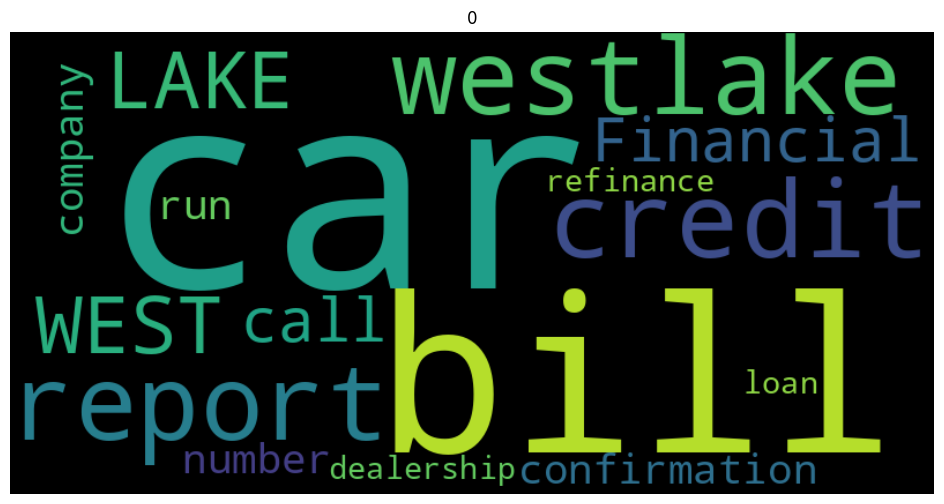

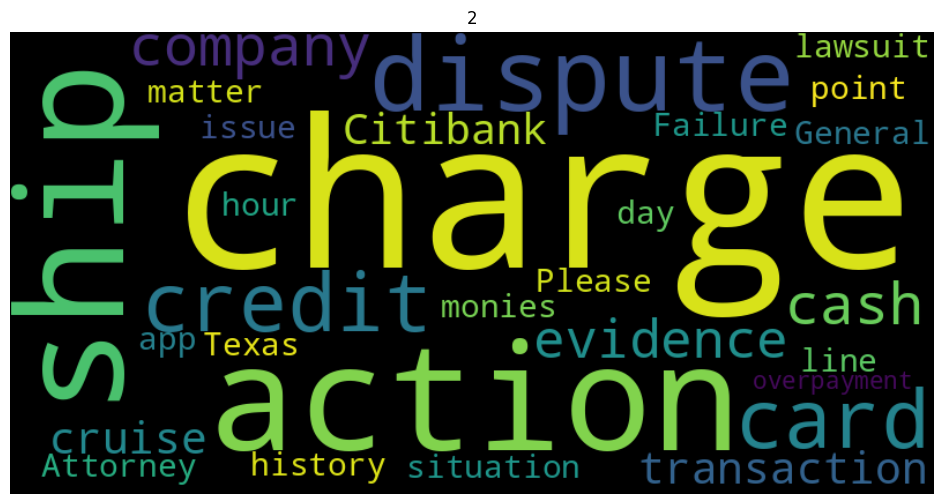

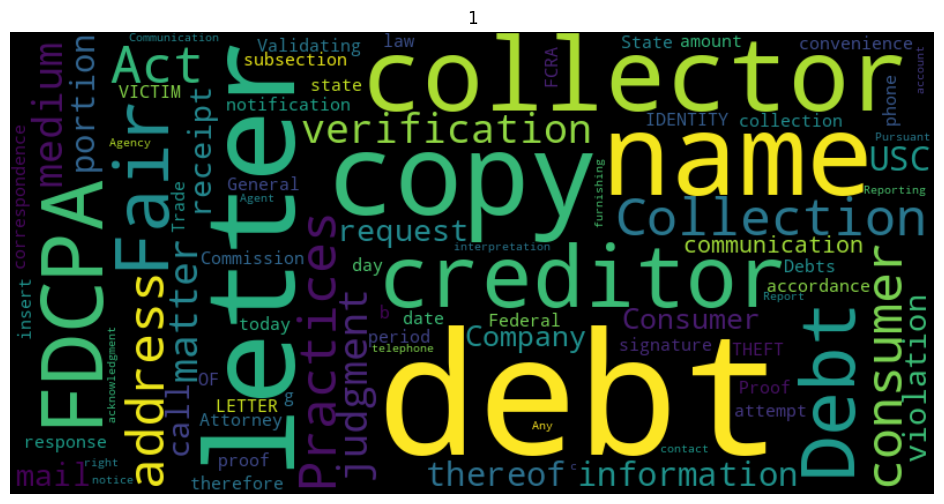

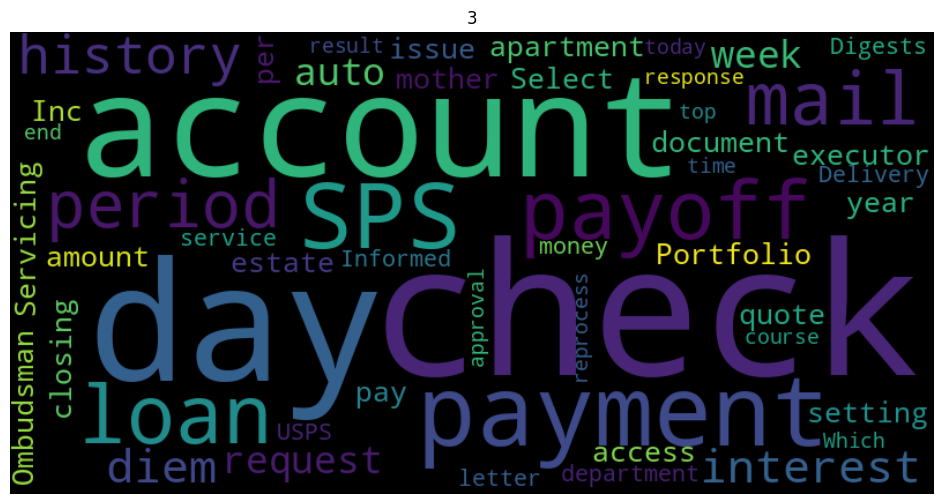

In [42]:
clustered_paragraphs_elmo = {}
for i, label in enumerate(labels_elmo):
    if label not in clustered_paragraphs_elmo:
        clustered_paragraphs_elmo[label] = []   
        clustered_paragraphs_elmo[label].append(paragraphs[i])

cleaned_paragraphs = {}

# getting labels and their tokens 
for label,paragraphs in clustered_paragraphs_elmo.items():
        wordcloud_logger.info('label: %d', label)
        tokens = [token for paragraph in paragraphs for token in word_tokenize(paragraph)]        
        nouns = extract_nouns(tokens, wordcloud_logger)        
        
        wordcloud_logger.info('label: %d, tokens len: %d', label, len(nouns))
    
        cleaned_paragraphs[label] = cleaned_paragraphs.get(label, []) + nouns       

# Count word frequency
word_counts = {}
for label, nouns in cleaned_paragraphs.items():
    counts = Counter(nouns)
    word_counts[label] = counts

# Generate word clouds
for label, counts in word_counts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(counts)
    plt.figure(figsize=(12, 6))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(label)    
    plt.savefig(f'wordcloud_{label}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [49]:
unique_labels, label_counts = np.unique(labels_elmo, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Cluster {label}: {count} costumer complaints")

Cluster 0: 214597 costumer complaints
Cluster 1: 54012 costumer complaints
Cluster 2: 132645 costumer complaints
Cluster 3: 98746 costumer complaints


### Plotting clusters of MiniBatchKmeans-ELMo Model 

In [50]:
#reducing dimensionality to plot the clusters

tsne = TSNE(n_components=2, random_state=42)  
elmo_embeddings_tsne = tsne.fit_transform(elmo_embeddings)
np.savetxt('elmo_embeddings_tsne.txt', elmo_embeddings_tsne)

In [51]:
print(elmo_embeddings_tsne.shape)

(500000, 2)


In [52]:
tsne_loaded_elmo = np.loadtxt('elmo_embeddings_tsne.txt')

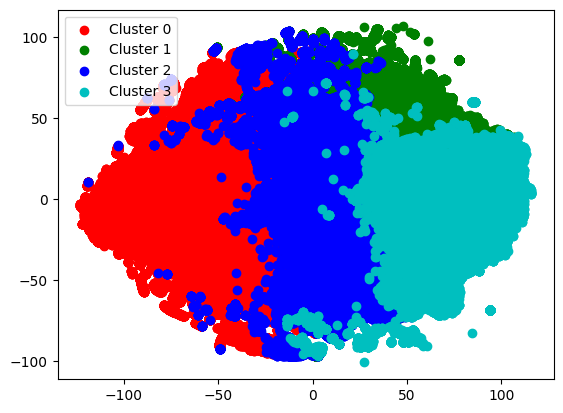

In [54]:
# Plot the clusters
colors = ['r', 'g', 'b', 'c']
for i in range(4):
    mask = [label == i for label in labels_elmo]
    cluster_tsne = elmo_embeddings_tsne[mask, :]
    plt.scatter(cluster_tsne[:,0],
                cluster_tsne[:,1],
                c=colors[i], label='Cluster {}'.format(i))
plt.legend()
plt.show()

#### InferSent Sentence Embeddings

##### STEPS OF INFERSENT SENTENCE EMBEDDINGS
1- Create a directory named fastText.

   - mkdir fastText

2- Download the FastText pre-trained word vectors (crawl-300d-2M.vec.zip) using curl and save it in the fastText directory.

   - curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

3- Extract the downloaded file (crawl-300d-2M.vec.zip) to the fastText directory using unzip.
   - unzip fastText/crawl-300d-2M.vec.zip -d fastText/

4- Create a directory named encoder

   - mkdir encoder
   
5- Download inferSent model trained with fastText
   - curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
   
6- Load models.py that contains the definiton of the InferSent model class.

In [3]:
import os

files_to_delete = ['logs/infersent.log', 'logs/models.log']

for file_to_delete in files_to_delete:
    if os.path.isfile(file_to_delete):
        os.remove(file_to_delete)
        print(f"The file '{file_to_delete}' has been deleted.")
    else:
        print(f"The file '{file_to_delete}' does not exist.")

The file 'logs/infersent.log' has been deleted.
The file 'logs/models.log' has been deleted.


In [4]:
logger= logging.getLogger('infersent')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('logs/infersent.log')
file_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)

In [5]:
# create a logger instance for models.py
logger_models= logging.getLogger('models')

logger_models.setLevel(logging.INFO)

file_handler = logging.FileHandler('logs/models.log')
file_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

file_handler.setFormatter(formatter)

logger_models.addHandler(file_handler)

In [6]:
# Check if GPU is available
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")          # Use GPU
else:
    print("cpu")
    device = torch.device("cpu")           # Use CPU
    
# load the InferSent model
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 128, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V,
                'logger':logger_models}
infersent = InferSent(params_model)
infersent.to(device)
infersent.load_state_dict(torch.load(MODEL_PATH))
 
W2V_PATH = 'fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

# Load embeddings of K most frequent words

infersent.build_vocab_k_words(K=1000000)
print('done')

cuda
done


#### Generating InferSent Embeddings Model 

In [7]:
def get_Infersent_Embeddings(text):
    embeddings = infersent.encode(text, bsize=128, tokenize=True, verbose=True)
    logger_models.info('nb sentences encoded : {0}'.format(len(embeddings)))
    return embeddings

In [11]:

column_name = 'Consumer complaint narrative'


row_chunk_size = 500

output_path = 'inferSent_embeddings_chunks.txt'
input_path = 'cleaned_text_data.txt'

# Open the CSV file and read the first chunk
filename = 'complaints.csv'
reader = pd.read_csv(filename, usecols=[column_name], chunksize=row_chunk_size)
chunk = next(reader)


max_total_chunks = 500000


total_time = 0

total_chunks = 0
chunk_size = 5

def embeddings(text, feature_extractor, total_sentence,logger):
    start_time = time.time()                    
    embeddings = feature_extractor(text)                    
    end_time = time.time()
    time_diff = end_time - start_time    
    logger.info('current total chunk: %d, current processed chunks size: %d, total sentences in chunk: %d , processing time: %f ',total_chunks, len(text), total_sentence, time_diff)
    
    return (embeddings, time_diff)


try:
    with contextlib.ExitStack() as stack:
        inferSent_output = stack.enter_context(open(output_path, 'w'))
        input_data = stack.enter_context(open(input_path, 'w'))

        while chunk is not None and total_chunks < max_total_chunks:
            
            selected_column = chunk[column_name]
            selected_column.dropna(inplace= True)
            selected_column.drop_duplicates(inplace= True)
                        
            if len(selected_column) > 0:
                text_total_chunks = len(selected_column) // chunk_size + (1 if len(selected_column) % chunk_size > 0 else 0)

                for i in range(text_total_chunks):
                    start_idx = i * chunk_size
                    end_idx = min((i + 1) * chunk_size, len(selected_column))

                    sub_text = selected_column.iloc[start_idx:end_idx]

                    if ((total_chunks + len(sub_text)) > max_total_chunks):
                        end_idx -= (total_chunks + len(sub_text)) - max_total_chunks
                        sub_text = selected_column.iloc[start_idx:end_idx]            
                        
                    total_sentence = sum(len(sent_tokenize(p)) for p in sub_text.values)
                    cleaned_text = clean_text(sub_text)

                    inferSent_embeddings = embeddings(sub_text,get_Infersent_Embeddings, total_sentence, logger)
                    np.savetxt(inferSent_output, inferSent_embeddings[0])
                    np.savetxt(input_data, cleaned_text, fmt="%s", delimiter='\n')
                    total_time += inferSent_embeddings[1]

                    total_chunks += len(sub_text)
                    if(total_chunks == max_total_chunks):
                        break;
                
            chunk = next(reader, None)                
except Exception as e:
        logger.exception('An unexpected error occurred: %s', str(e))


logger.info("Total chunks size: " + str(total_chunks))        
logger.info("Total processing time: " + str(total_time) + " seconds")
print('done')

done


In [90]:
embeddings_inferSent = np.loadtxt('inferSent_embeddings_chunks.txt')

In [92]:
embeddings_inferSent.shape

(500000, 4096)

#### MiniBatchKmeans with InferSent

296.46692061424255


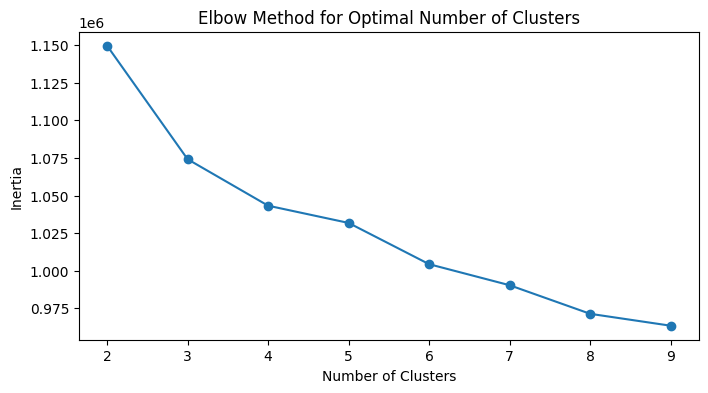

In [44]:
# Elbow method

cluster_range = range(2, 10)

# Using the Elbow Method with MiniBatchKMeans
inertias = []

start_time = time.time() 

with parallel_backend(backend='loky', n_jobs=-1):
    for n_clusters in cluster_range:
        mbkmeans_infersent = MiniBatchKMeans(n_clusters=n_clusters, n_init = 'auto', batch_size=2048, random_state=42, max_iter=100, verbose=0)
        mbkmeans_infersent.fit(embeddings_inferSent)
        inertias.append(mbkmeans_infersent.inertia_)

        
end_time = time.time()        
print(end_time - start_time)

plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [91]:
mbkmeans_inferSent = MiniBatchKMeans(n_clusters=3, n_init = 'auto', batch_size=2048, random_state=42, max_iter=100, verbose=0)
start_time = time.time()
mbkmeans_inferSent.fit(embeddings_inferSent)
end_time = time.time()
total_time_inferSent = end_time - start_time
print(total_time_inferSent)
labels_inferSent = mbkmeans_inferSent.labels_
print(len(labels_inferSent))

31.797948360443115
500000


In [61]:
unique_labels, label_counts = np.unique(labels_inferSent, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Cluster {label}: {count} costumer complaints")

Cluster 0: 93396 costumer complaints
Cluster 1: 234342 costumer complaints
Cluster 2: 172262 costumer complaints


#### Plotting Clusters

In [46]:
# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
inferSent_embeddings_tsne = tsne.fit_transform(embeddings_inferSent)
np.savetxt('infersent_embeddings_tsne.txt', inferSent_embeddings_tsne)
print(inferSent_embeddings_tsne.shape)

(500000, 2)


In [77]:
tsne_loaded_inferSent = np.loadtxt('infersent_embeddings_tsne.txt')

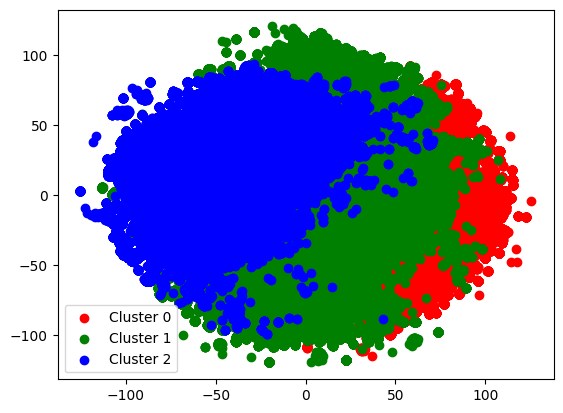

In [48]:
# Plot the clusters
colors = ['r', 'g', 'b']
for i in range(3):
    mask = [label == i for label in labels_inferSent]
    cluster_tsne = inferSent_embeddings_tsne[mask, :]
    cluster_tsne = inferSent_embeddings_tsne[mask, :]
    plt.scatter(cluster_tsne[:,0],
                cluster_tsne[:,1],
                c=colors[i], label='Cluster {}'.format(i))
plt.legend()
plt.show()
 

#### Word cloud for each generated cluster

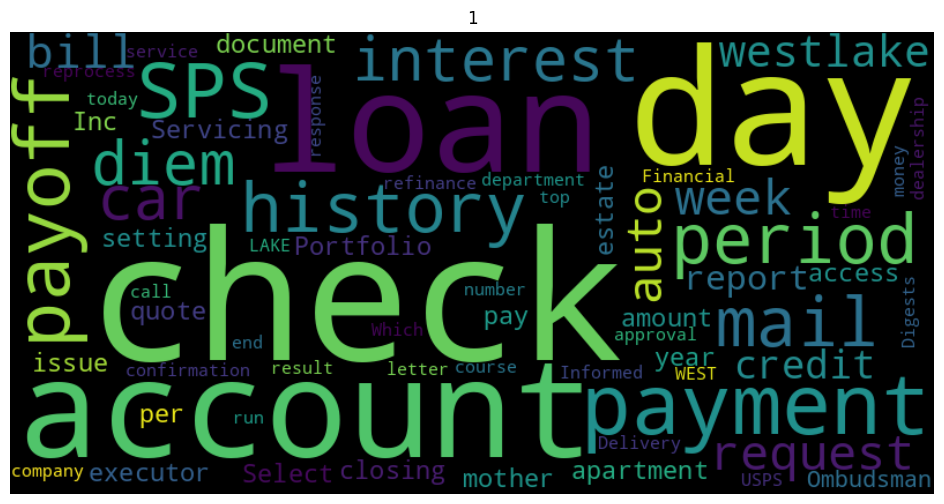

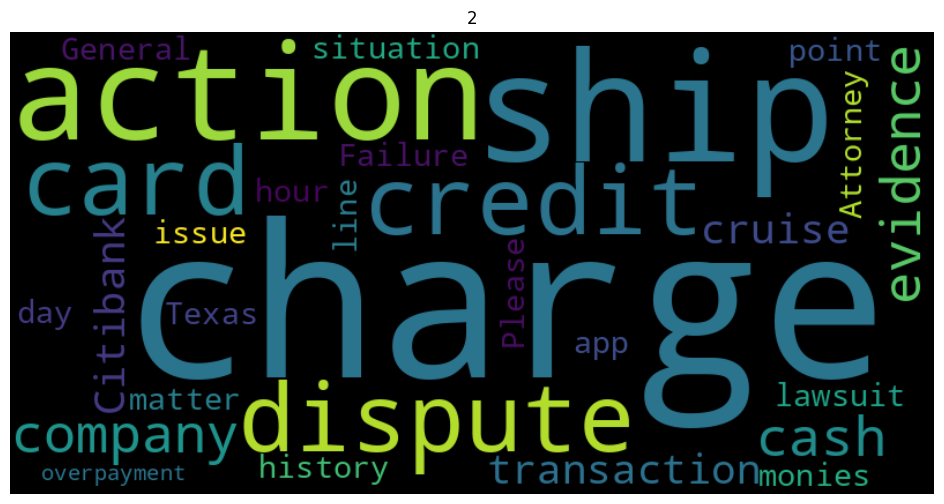

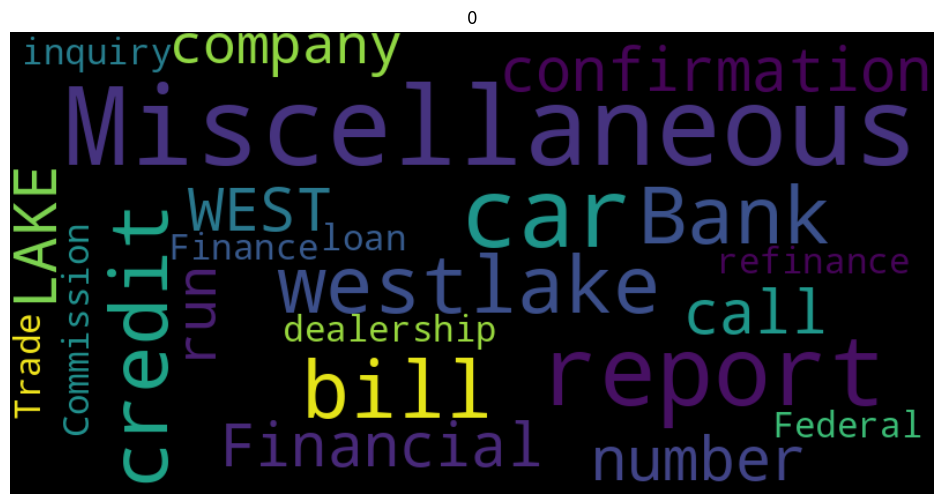

In [54]:
clustered_paragraphs_inferSent = {}
for i, label in enumerate(labels_inferSent):
    if label not in clustered_paragraphs_inferSent:
        clustered_paragraphs_inferSent[label] = []   
        clustered_paragraphs_inferSent[label].append(paragraphs[i])

cleaned_paragraphs_inferSent = {}

# getting labels and their tokens 
for label,paragraphs in clustered_paragraphs_inferSent.items():
        wordcloud_logger.info('label: %d', label)
        tokens = [token for paragraph in paragraphs for token in word_tokenize(paragraph)]        
        nouns = extract_nouns(tokens, wordcloud_logger)        
        
        wordcloud_logger.info('label: %d, tokens len: %d', label, len(nouns))
    
        cleaned_paragraphs_inferSent[label] = cleaned_paragraphs.get(label, []) + nouns       

# Count word frequency
word_counts = {}
for label, nouns in cleaned_paragraphs_inferSent.items():
    counts = Counter(nouns)
    word_counts[label] = counts

# Generate word clouds
for label, counts in word_counts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(counts)
    plt.figure(figsize=(12, 6))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(label)    
    plt.savefig(f'wordcloud_{label}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Compare MiniBatchKmeans Models with ELMo und InferSent

#### 1) Inertia (Within-Cluster Sum of Squares, WCSS):

In [62]:

# Compare Inertia
print("Inertia for MiniBatchKMeans ELMo:", mbkmeans_elmo.inertia_)
print("Inertia for MiniBatchKMeans InferSent:", mbkmeans_inferSent.inertia_)

Inertia for MiniBatchKMeans ELMo: 2251607.0293345614
Inertia for MiniBatchKMeans InferSent: 1074134.0152747426


##### 2) Silhouette Score

In [63]:

# Calculate Silhouette Scores
silhouette_elmo = silhouette_score(elmo_embeddings, labels_elmo, sample_size=100000 , random_state= 42)
silhouette_inferSent = silhouette_score(embeddings_inferSent, labels_inferSent, sample_size=100000 , random_state= 42)

# Compare Silhouette Scores
print("Silhouette Score for MiniBatchKMeans ELMo:", silhouette_elmo)
print("Silhouette Score for MiniBatchKMeans InferSent:", silhouette_inferSent)


Silhouette Score for MiniBatchKMeans ELMo: 0.3026138181589362
Silhouette Score for MiniBatchKMeans InferSent: 0.08710766826512988


##### 3) Calinski-Harabasz Index

In [64]:
# Calculate Calinski-Harabasz Index
ch_elmo= calinski_harabasz_score(elmo_embeddings, labels_elmo)
ch_inferSent = calinski_harabasz_score(embeddings_inferSent, labels_inferSent)

# Compare Calinski-Harabasz Index
print("Calinski-Harabasz Index for MiniBatchKMeans ELMo:", ch_elmo)
print("Calinski-Harabasz Index for MiniBatchKMeans InferSent:", ch_inferSent)

Calinski-Harabasz Index for MiniBatchKMeans ELMo: 234100.1100354082
Calinski-Harabasz Index for MiniBatchKMeans InferSent: 73541.26529551731


#### 4) Davies-Bouldin Index

In [95]:
# Calculate Davies-Bouldin Index
db_elmo = davies_bouldin_score(elmo_embeddings, labels_elmo)
db_inferSent = davies_bouldin_score(embeddings_inferSent, labels_inferSent)

# Compare Davies-Bouldin Index
print("Davies-Bouldin Index for MiniBatchKMeans ELMo :", db_elmo)
print("Davies-Bouldin Index for MiniBatchKMeans InferSent:", db_inferSent)

Davies-Bouldin Index for MiniBatchKMeans ELMo : 1.6826730504760832
Davies-Bouldin Index for MiniBatchKMeans InferSent: 2.6340165403839175


#### Fitting the Model After TSNE

82.96787977218628


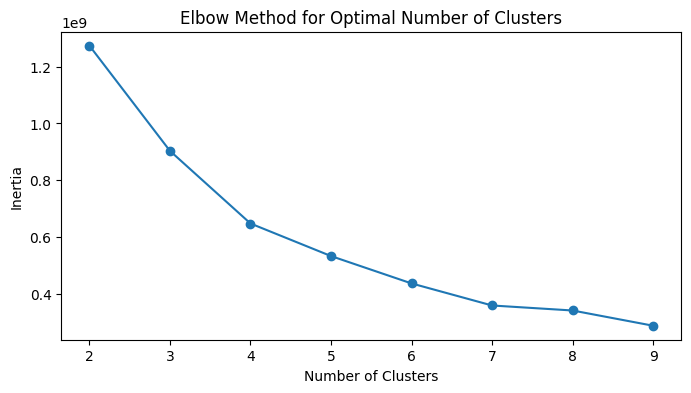

In [66]:
# Using the Elbow Method with MiniBatchKMeans

cluster_range = range(2, 10)
inertias = []

start_time = time.time() 

with parallel_backend(backend='loky', n_jobs=-1):
    for n_clusters in cluster_range:
        mbkmeans_elmo_tsne = MiniBatchKMeans(n_clusters=n_clusters, n_init = 'auto', batch_size=2048, random_state=42, max_iter=100, verbose=0)
        mbkmeans_elmo_tsne.fit(tsne_loaded_elmo)
        inertias.append(mbkmeans_elmo_tsne.inertia_)

        
end_time = time.time()         
print(end_time - start_time)

plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [67]:
mbkmeans_elmo_tsne = MiniBatchKMeans(n_clusters=4, n_init = 'auto', batch_size=2048, random_state=42, max_iter=100, verbose=0)
start_time = time.time()
mbkmeans_elmo_tsne = mbkmeans_elmo_tsne.fit(tsne_loaded_elmo)
end_time = time.time() 
total_time_elmo_tsne = end_time - start_time
print(total_time_elmo_tsne)
labels_elmo_tsne= mbkmeans_elmo_tsne.labels_
print(len(labels_elmo_tsne))

12.610051393508911
500000


#### Wordcloud

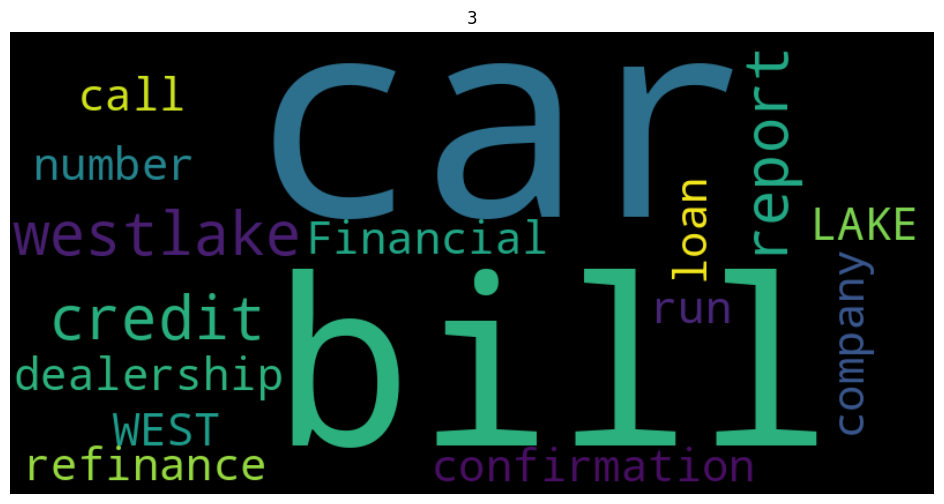

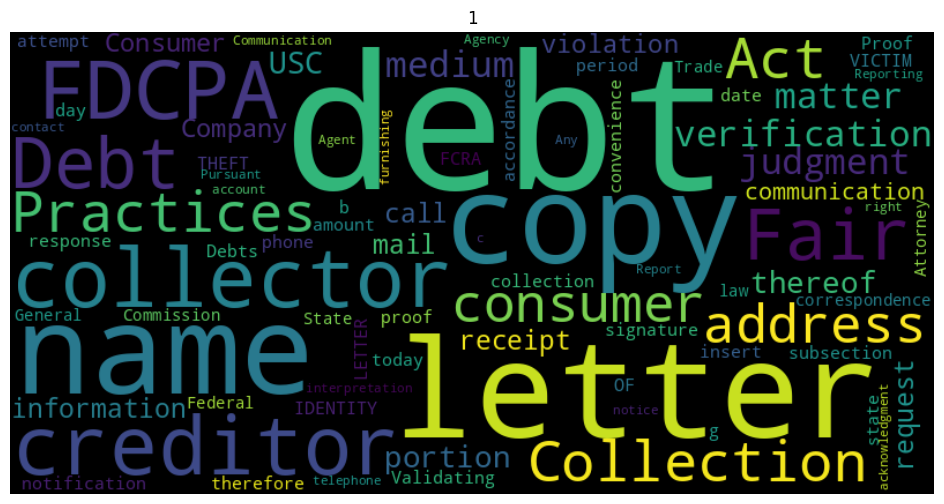

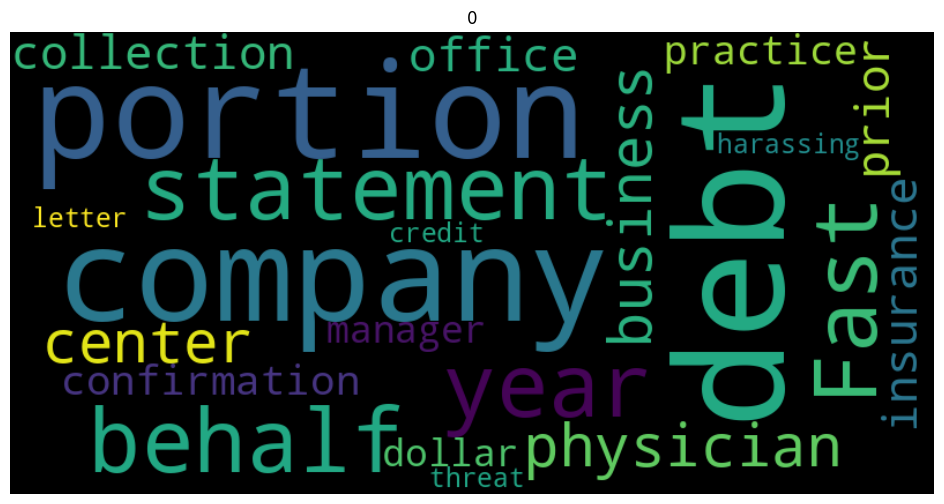

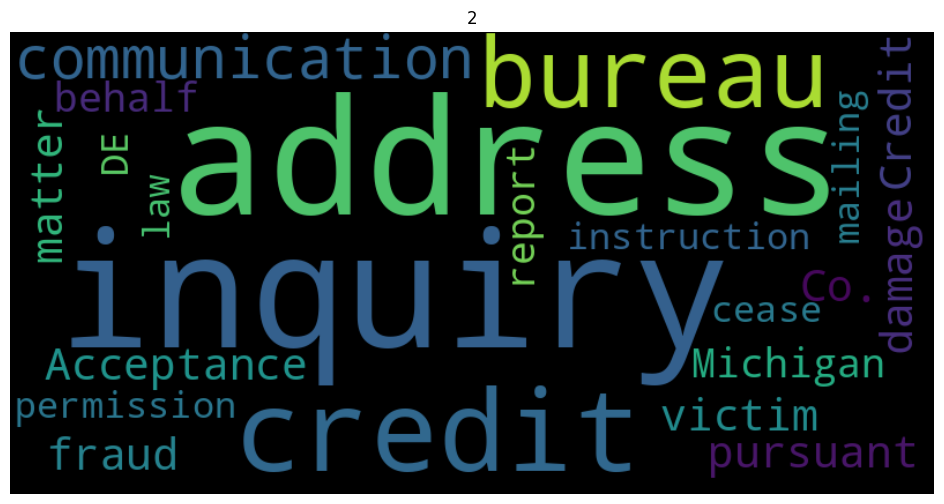

In [74]:
clustered_paragraphs_elmo = {}
for i, label in enumerate(labels_elmo_tsne):
    if label not in clustered_paragraphs_elmo:
        clustered_paragraphs_elmo[label] = []   
        clustered_paragraphs_elmo[label].append(paragraphs[i])

cleaned_paragraphs = {}

# getting labels and their tokens 
for label,paragraphs in clustered_paragraphs_elmo.items():
        wordcloud_logger.info('label: %d', label)
        tokens = [token for paragraph in paragraphs for token in word_tokenize(paragraph)]        
        nouns = extract_nouns(tokens, wordcloud_logger)        
        
        wordcloud_logger.info('label: %d, tokens len: %d', label, len(nouns))
    
        cleaned_paragraphs[label] = cleaned_paragraphs.get(label, []) + nouns       

# Count word frequency
word_counts = {}
for label, nouns in cleaned_paragraphs.items():
    counts = Counter(nouns)
    word_counts[label] = counts

# Generate word clouds
for label, counts in word_counts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(counts)
    plt.figure(figsize=(12, 6))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(label)    
    plt.savefig(f'wordcloud_{label}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [75]:
unique_labels, label_counts = np.unique(labels_elmo_tsne, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Cluster {label}: {count} costumer complaints")

Cluster 0: 126677 costumer complaints
Cluster 1: 128746 costumer complaints
Cluster 2: 112354 costumer complaints
Cluster 3: 132223 costumer complaints


#### Infersent with tsNE input 

87.62329125404358


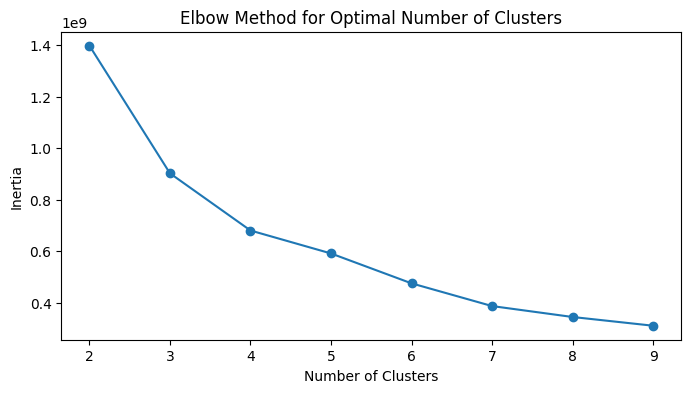

In [78]:
# Elbow method

cluster_range = range(2, 10)

inertias = []

start_time = time.time() 

with parallel_backend(backend='loky', n_jobs=-1):
    for n_clusters in cluster_range:
        mbkmeans_infersent_tsne = MiniBatchKMeans(n_clusters=n_clusters, n_init = 'auto', batch_size=2048, random_state=42, max_iter=100, verbose=0)
        mbkmeans_infersent_tsne.fit(tsne_loaded_inferSent)
        inertias.append(mbkmeans_infersent_tsne.inertia_)

        
end_time = time.time()        
print(end_time - start_time)

plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [79]:
mbkmeans_inferSent_tsne = MiniBatchKMeans(n_clusters=4, n_init = 'auto', batch_size=2048, random_state=42, max_iter=100, verbose=0)
start_time = time.time()
mbkmeans_inferSent_tsne.fit(tsne_loaded_inferSent)
end_time = time.time()
total_time_inferSent_tsne = end_time - start_time
print(total_time_inferSent_tsne)
labels_inferSent_tsne = mbkmeans_inferSent_tsne.labels_

7.9946510791778564


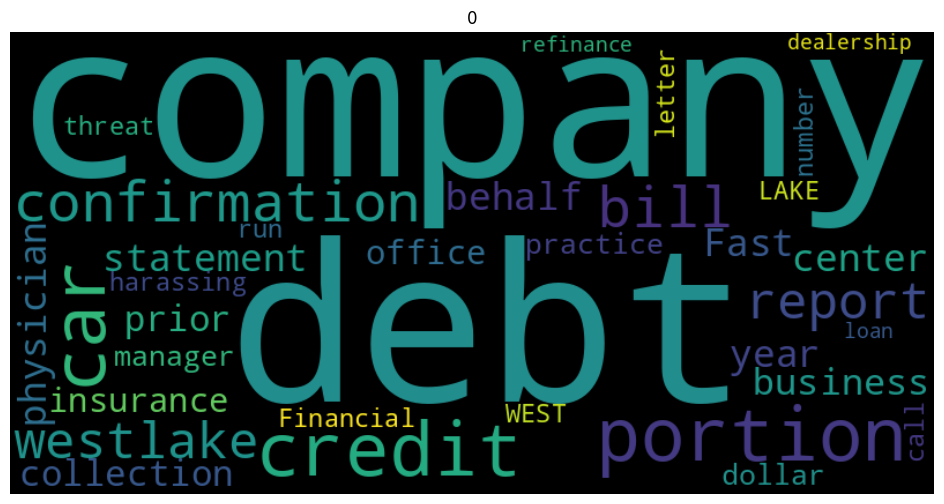

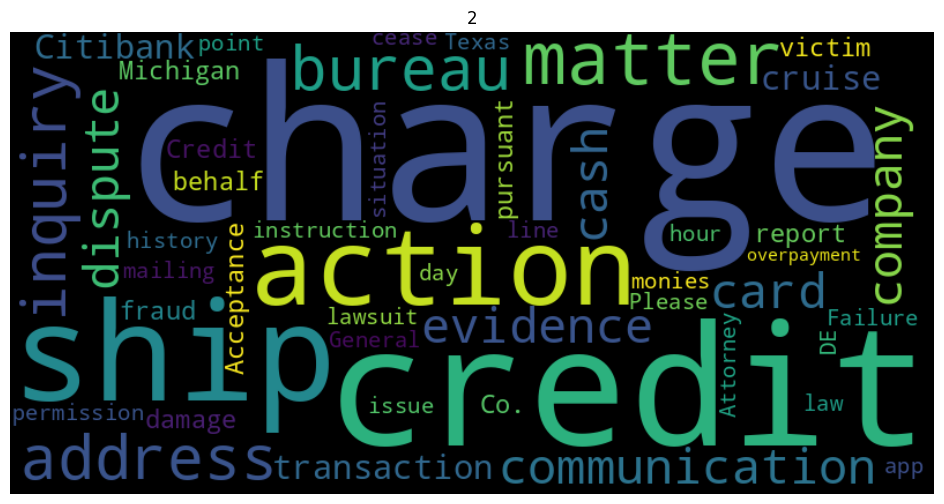

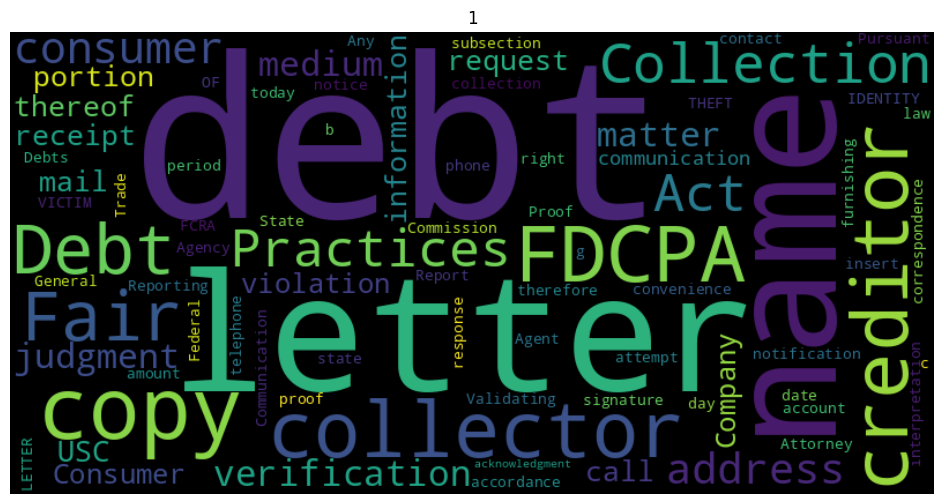

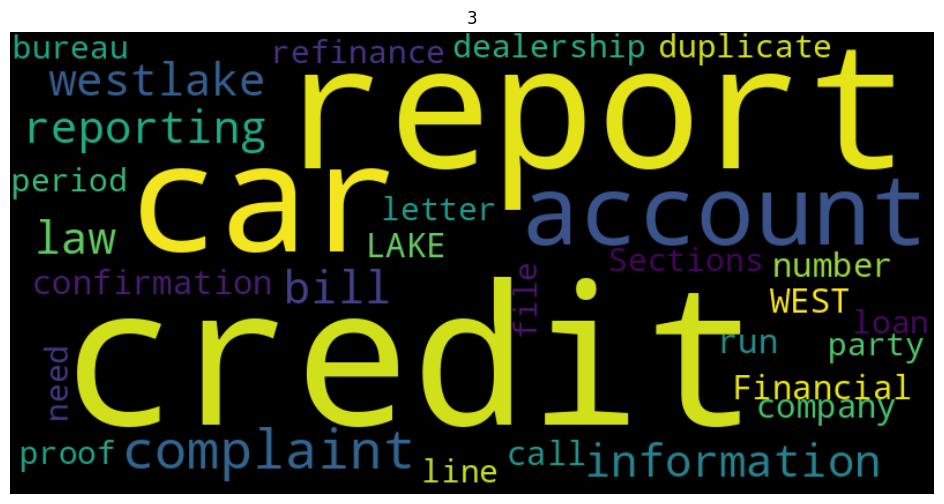

In [83]:
clustered_paragraphs_inferSent_tsne = {}
for i, label in enumerate(labels_inferSent_tsne):
    if label not in clustered_paragraphs_inferSent_tsne:
        clustered_paragraphs_inferSent_tsne[label] = []   
        clustered_paragraphs_inferSent_tsne[label].append(paragraphs[i])

cleaned_paragraphs_inferSent_tsne = {}

# getting labels and their tokens 
for label,paragraphs in clustered_paragraphs_inferSent_tsne.items():
        wordcloud_logger.info('label: %d', label)
        tokens = [token for paragraph in paragraphs for token in word_tokenize(paragraph)]        
        nouns = extract_nouns(tokens, wordcloud_logger)        
        
        wordcloud_logger.info('label: %d, tokens len: %d', label, len(nouns))
    
        cleaned_paragraphs_inferSent_tsne[label] = cleaned_paragraphs.get(label, []) + nouns       

# Count word frequency
word_counts = {}
for label, nouns in cleaned_paragraphs_inferSent_tsne.items():
    counts = Counter(nouns)
    word_counts[label] = counts

# Generate word clouds
for label, counts in word_counts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(counts)
    plt.figure(figsize=(12, 6))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(label)    
    plt.savefig(f'wordcloud_{label}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [84]:
unique_labels, label_counts = np.unique(labels_inferSent_tsne, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Cluster {label}: {count} costumer complaints")

Cluster 0: 130433 costumer complaints
Cluster 1: 114383 costumer complaints
Cluster 2: 151473 costumer complaints
Cluster 3: 103711 costumer complaints


### Compare MiniBatchKmeans Models with ELMo und InferSent After T-SNE

#### 1) Inertia (Within-Cluster Sum of Squares, WCSS):

In [85]:
# Compare Inertia
print("Inertia for MiniBatchKMeans ELMo:", mbkmeans_elmo_tsne.inertia_)
print("Inertia for MiniBatchKMeans InferSent:", mbkmeans_infersent_tsne.inertia_)

Inertia for MiniBatchKMeans ELMo: 647495349.965644
Inertia for MiniBatchKMeans InferSent: 310661481.3230867


##### 2) Silhouette Score

In [86]:
# Calculate Silhouette Scores
silhouette_elmo = silhouette_score(tsne_loaded_elmo, labels_elmo_tsne, sample_size = 100000, random_state= 42)
silhouette_inferSent = silhouette_score(tsne_loaded_inferSent, labels_inferSent_tsne, sample_size = 100000, random_state= 42)


print("Silhouette Score for MiniBatchKMeans ELMo:", silhouette_elmo)
print("Silhouette Score for MiniBatchKMeans InferSent:", silhouette_inferSent)


Silhouette Score for MiniBatchKMeans ELMo: 0.3710114021115892
Silhouette Score for MiniBatchKMeans InferSent: 0.35269160706779845


##### 3) Calinski-Harabasz Index

In [87]:
# Calculate Calinski-Harabasz Index
ch_elmo= calinski_harabasz_score(tsne_loaded_elmo, labels_elmo_tsne)
ch_inferSent = calinski_harabasz_score(tsne_loaded_inferSent, labels_inferSent_tsne)


print("Calinski-Harabasz Index for MiniBatchKMeans ELMo:", ch_elmo)
print("Calinski-Harabasz Index for MiniBatchKMeans InferSent:", ch_inferSent)

Calinski-Harabasz Index for MiniBatchKMeans ELMo: 437204.68522700487
Calinski-Harabasz Index for MiniBatchKMeans InferSent: 392207.7831468126


#### 4) Davies-Bouldin Index

In [89]:
# Calculate Davies-Bouldin Index
db_elmo = davies_bouldin_score(tsne_loaded_elmo, labels_elmo_tsne)
db_inferSent = davies_bouldin_score(tsne_loaded_inferSent, labels_inferSent_tsne)


print("Davies-Bouldin Index for MiniBatchKemans ELMo:", db_elmo)
print("Davies-Bouldin Index for MiniBatchKmeans InferSent:", db_inferSent)

Davies-Bouldin Index for MiniBatchKemans ELMo: 0.8815940368153958
Davies-Bouldin Index for MiniBatchKmeans InferSent: 0.8774413169292832
